In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap

from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Описание задачи

Поиск анамолий в данных с банковскими транзакциями.

Загрузим датасет и ознакомимся с ним. Исходный датасет взят с сайта Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

In [6]:
data = pd.read_csv('creditcard.csv', sep=',', decimal='.', encoding='CP1251')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## EDA

Проведем первичный анализ данных. Посмотрим на типы данных и проверим есть ли наличие пропусков.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Как мы видим, в нашем датасете нет пропусков. В датасете присутствуют 28 компонент, полученных при помощи PCA.
Также в датасете присутствуют следующие столбцы:
- Time - количество секунд, прошедших между текущей и первой транзакцией.
- Amount - сумма сделки.
- Class - определяет является ли транзакция мошеннической.

Посмотрим на описательные статистики наших данных и построим гистограммы.

In [9]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


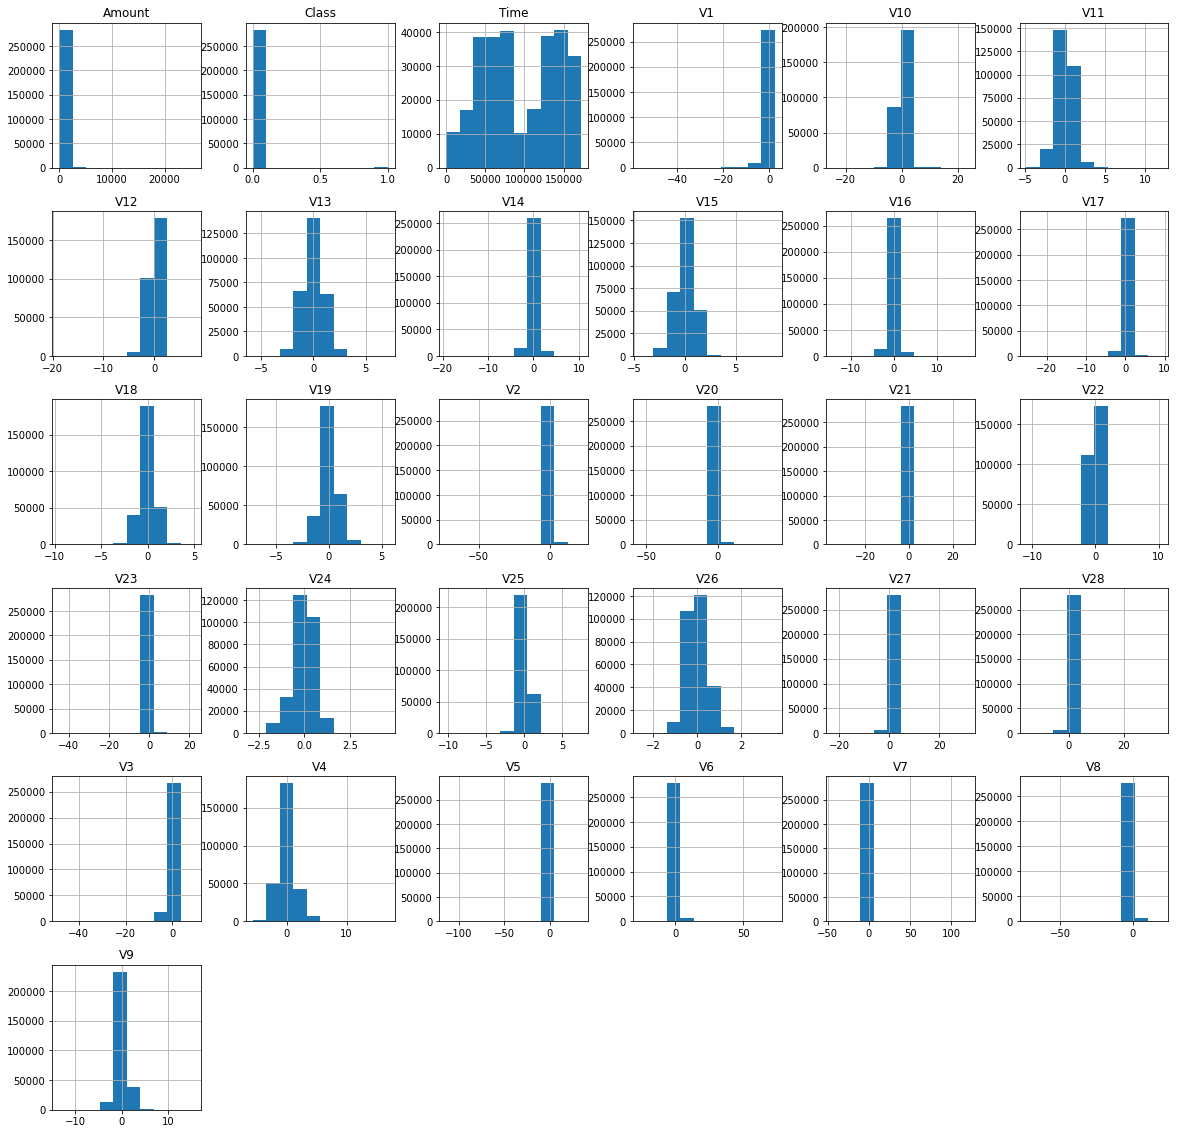

In [10]:
data.hist(figsize=(20, 20));

По гистограммам мы видим, что по компонентам V4, V13, V15, V18, V19 распределение приближено к нормальному распределению. Также более менее нормально распределены компоненты V11, V24 и V26. По остальным компонентам и переменным Amount и Time нормального распределения не наблюдается.

In [11]:
data_features = data.iloc[:, :-1]

Посмотрим на общий процент аномалий в наших данных, согласно переменной Class.

In [12]:
(data['Class'].value_counts() / len(data)) * 100

0    99.827251
1     0.172749
Name: Class, dtype: float64

Мы видим, что в наших данных всего 0,2% анамолий.

Далее запишем функцию для расчет метрик на основе confusion matrix при сравнении с другими методами.

In [13]:
def quality_report(prediction, actual, model):
    quality_data = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'f1_score'], index=[model])
    
    quality_data['Accuracy'] = round(accuracy_score(prediction, actual), 3)
    quality_data['Precision'] = round(precision_score(prediction, actual), 3)
    quality_data['Recall'] = round(recall_score(prediction, actual), 3)
    quality_data['f1_score'] = round(f1_score(prediction, actual), 3)
    
    return quality_data

# Расчет %-та аномалий с помощью правила 3 сигм.

С помощью правила 3-сигм посмотрим сколько данных у нас с аномалиями. Запишем функции.

In [14]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns
        
    outliers = pd.Series(data=[False]*len(data), index=data_features.index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True
    
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    comparison_table = comparison_table.sort_values(by='anomalies_percentage', ascending=False)
    
    return comparison_table, outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))    

In [15]:
comparison_table, std_outliers = get_column_outliers(data_features)
anomalies_report(std_outliers)

Total number of outliers: 37816
Percentage of outliers:   13.28%


В наших данных порядка 13% данных с аномалиями. Посмотрим в каких переменных аномалий больше всего и меньше всего.

In [16]:
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
V27,1.210897,-1.210897,4771.0,1.675170
V6,3.996813,-3.996813,4652.0,1.633387
V20,2.312775,-2.312775,4645.0,1.630929
V2,4.953926,-4.953926,4318.0,1.516114
V8,3.583059,-3.583059,4221.0,1.482056
Amount,838.709947,-662.010708,4076.0,1.431145
V21,2.203572,-2.203572,4064.0,1.426931
V1,5.876087,-5.876087,3701.0,1.299476
V10,3.266549,-3.266549,3488.0,1.224689
V7,3.711281,-3.711281,3401.0,1.194142


В целом мы видим, что по тем переменным, по которым на гистаграммах прослеживалось нормальное распределение, процент аномалий низок (например, компоненты V13, V15, V11). По переменным, по которым нормальное распределение не наблюдалось, процент аномалий высок (например, Amount, V1, V2, V20, V21). Стоит отметить, что по переменной Time анамолий не найдено несмотря на то, что данные распределены не совсем нормально.

Теперь сделаем визуализацию с помощью pairplot. Чтобы не строить все графики, возьмем три переменные с наименьшим количеством аномалий, одну примерно со средним значенеим, и две переменные с наивысшим значением аномалий.

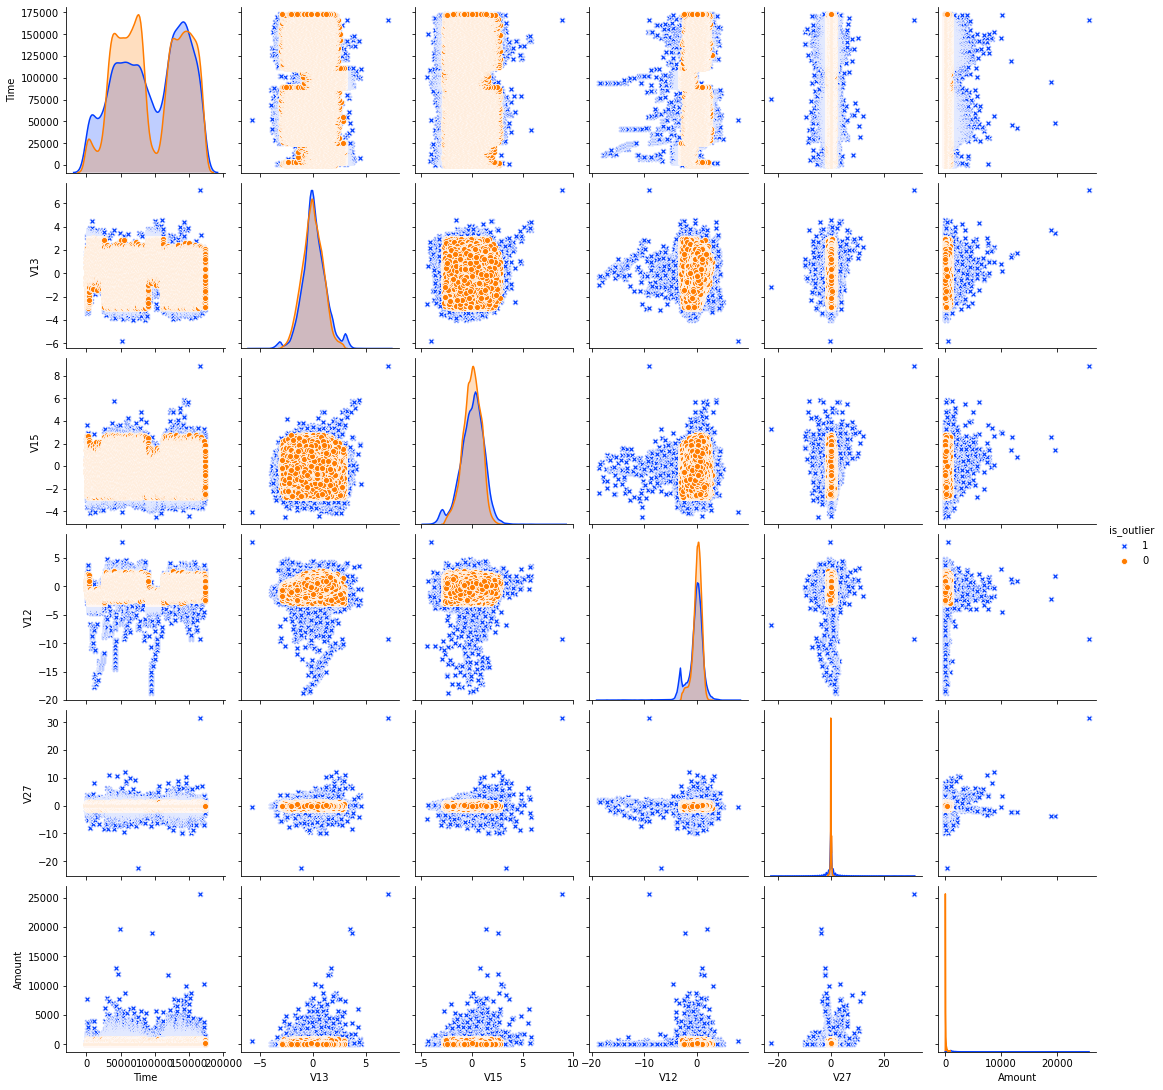

In [17]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = std_outliers

sns.pairplot(data=labeled_data, vars = data_features[['Time', 'V13', 'V15', 'V12', 'V27', 'Amount']],
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

На графиках мы видим, что в компонентах V13, V15 и переменной Time аномальных значений (синих точек) практически нет. На компоненте V12 мы можем наблюдать, что аномальных значений становится больше. На компоненте V27 и Amount можем наблюдать большое количество аномалий.

Рассчитаем метрики качества для оценки качества данного метода поиска аномалий.

In [18]:
std_data = pd.concat((labeled_data[['is_outlier']], data['Class']), axis=1)
std_data['is_outlier'] = np.where(std_data['is_outlier'] == True, 1, 0)
std_data.head()

,is_outlier,Class
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [19]:
std_report = quality_report(std_data['is_outlier'], std_data['Class'], 'std')
std_report

,Accuracy,Precision,Recall,f1_score
std,0.869,0.902,0.012,0.023


Как мы видим, при данном методе мы практически не угадываем аномальные значения, согласно переменной Class. Recall на уровне 1%.

# Межквартильное отклонение
Теперь посмотрим на процент аномалий с помощью межквартильного отклонения. Построим графики box-plots. Чтобы не строить графики по всем переменным, построим графики по нескольким переменным. Из группы с низким высоким %-м аномалий.

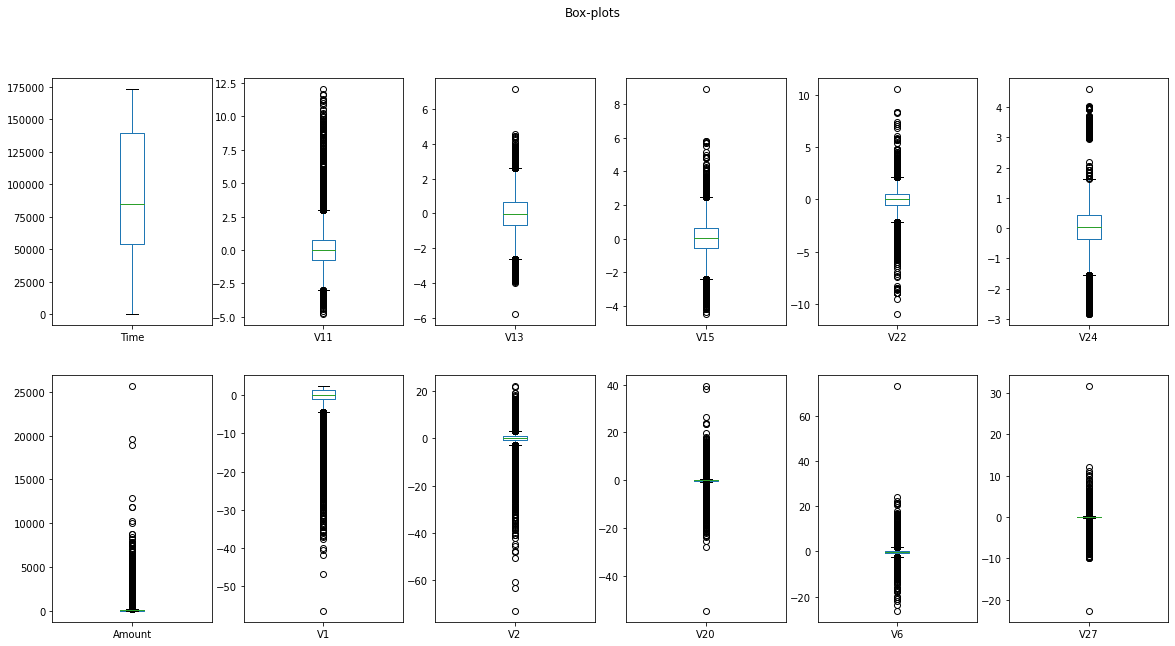

In [20]:
fig, axes = plt.subplots(2, 6, figsize=(20, 10))
fig.suptitle('Box-plots')

row=0
col=0

for ax, feature in enumerate(data_features[['Time', 'V11', 'V13', 'V15', 'V22', 'V24', 'Amount', 'V1', 'V2', 'V20', 'V6', 'V27']]):
    data_features[feature].plot.box(ax=axes[row, col])
    col+=1
    if col > 5:
        row+=1
        col=0

Исходя из полученных графиков мы видим, что в переменной Time нет выбросов. По компонентам, изображенным в верхнем ряду наблюдается несильный разброс значений. В то же время по остальным компонентам и переменной Amount в нижнем ряду наблюдается достаточно много выбросов, включая и экстремальные значения.

Рассчитаем какой процент аномалий найден в каждой переменной.

In [21]:
def outlier_iqr(data, col, threshold=3):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    up_bound = data[col].quantile(0.75) + (IQR * threshold)
    low_bound = data[col].quantile(0.25) - (IQR * threshold)
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [22]:
comparison_table, iqr_outliers = get_column_outliers(data_features, function=outlier_iqr)
anomalies_report(iqr_outliers)

Total number of outliers: 53336
Percentage of outliers:   18.73%


В наших данных порядка 19% данных с аномалиями, согласно подсчету с помощью межквартильного отклонения. Посмотрим в каких переменных аномалий больше всего и меньше всего.

In [23]:
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
Amount,291.860000,-209.095000,18941.0,6.650469
V27,0.576699,-0.556493,16524.0,5.801824
V20,1.167327,-1.246008,13385.0,4.699674
V28,0.471999,-0.446679,12573.0,4.414568
V8,1.935273,-1.816557,11285.0,3.962332
V23,1.076107,-1.090312,8135.0,2.856320
V21,1.430694,-1.472711,6934.0,2.434631
V6,3.899146,-4.268877,5389.0,1.892159
V2,5.010545,-4.805371,4453.0,1.563515
V10,3.421971,-3.503473,3208.0,1.126377


В целом мы видим, что по тем переменным, по которым на гистаграммах прослеживалось нормальное распределение и, по которым с помощью правило трех сигм было низкое, процент аномалий низок (например, компоненты V13, V15, V11). Можно сделать вывод, что по нормально распределенным данным аномалий практически нет.
По переменным, по которым нормальное распределение не наблюдалось, процент аномалий высок (например, Amount, V20, V21, V27).

Теперь сделаем визуализацию с помощью pairplot. Чтобы не строить все графики, возьмем три переменные с наименьшим количеством аномалий, одну примерно со средним значенеим, и две переменные с наивысшим значением аномалий.

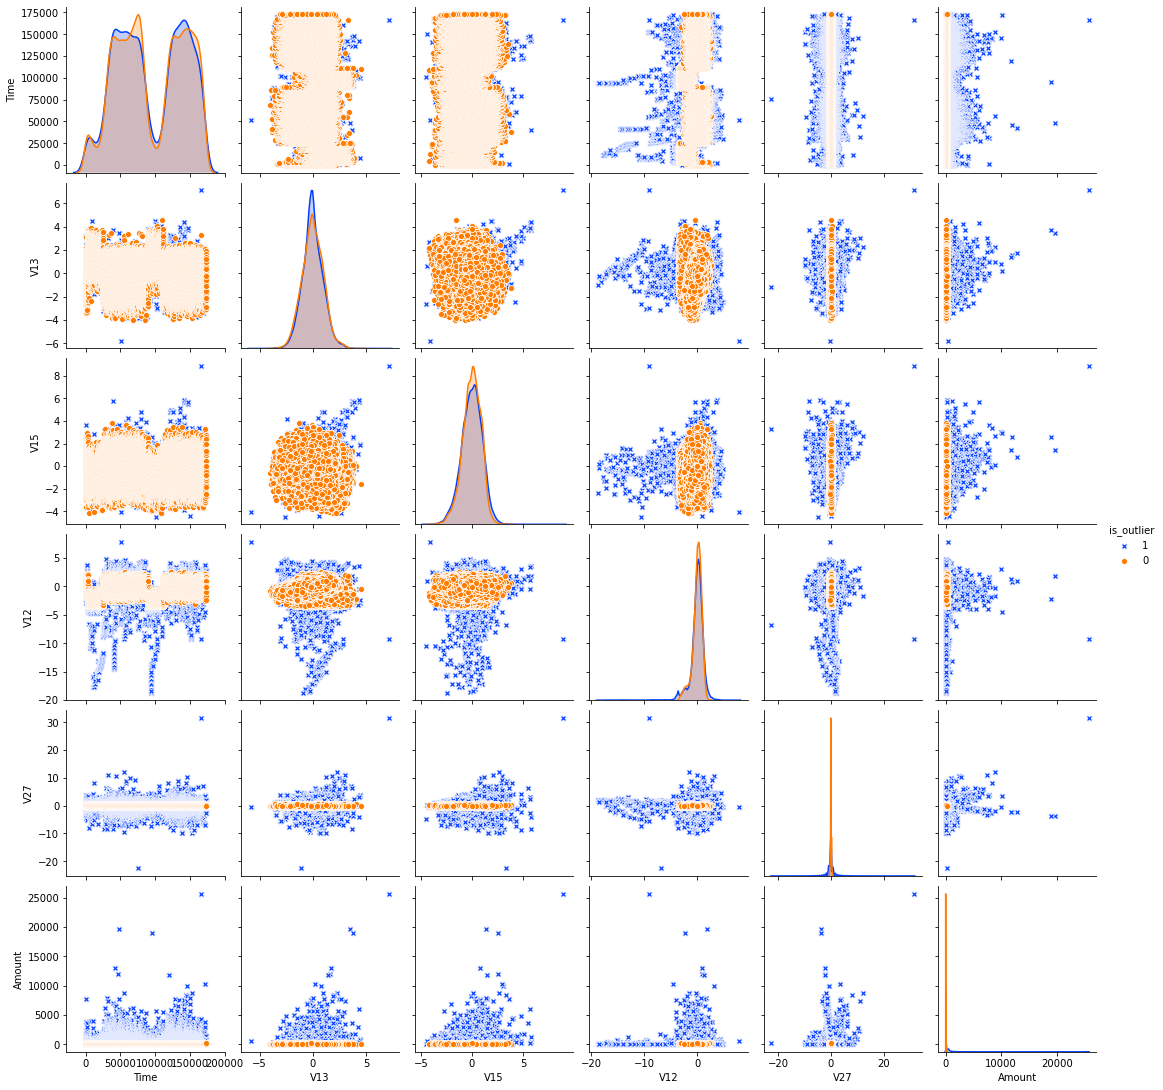

In [24]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = iqr_outliers

sns.pairplot(data=labeled_data, vars = data_features[['Time', 'V13', 'V15', 'V12', 'V27', 'Amount']],
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

На графиках мы видим, что в компонентах V13, V15 и переменной Time аномальных значений (синих точек) практически нет. На компоненте V12 мы можем наблюдать, что аномальных значений становится больше. На компоненте V27 и Amount можем наблюдать большое количество аномалий. В целом картина схожа с предыдущим методом поиска аномалий.

Рассчитаем метрики качества для оценки качества данного метода поиска аномалий.

In [25]:
iqr_data = pd.concat((labeled_data[['is_outlier']], data['Class']), axis=1)
iqr_data['is_outlier'] = np.where(iqr_data['is_outlier'] == True, 1, 0)
iqr_data.head()

,is_outlier,Class
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [26]:
iqr_report = quality_report(iqr_data['is_outlier'], iqr_data['Class'], 'iqr')
iqr_report

,Accuracy,Precision,Recall,f1_score
iqr,0.814,0.919,0.008,0.017


Как мы видим, при данном методе мы практически не угадываем аномальные значения, согласно переменной Class. Recall на уровне 0.8% (ниже, чем в предыдущем методе).

# Поиск аномалий с помощью кластеризации.
# Distance-based
Теперь посмотрим на процент аномалий с помощью кластеризации. Для начала приведем все наши данные к единой размерности.

In [27]:
class DistanceOutliers(BaseEstimator):
    """
    -----------
    Parameters:
    
    - metric: string, default - euclidean
        metric to use for distance calculation (see scipy.spatial.distance.cdist)
        
    - percentile: float in range [0, 100]
        hyperparameter which sets the threshold for anomalies
    """
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

In [28]:
scaler = RobustScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(data_features), 
    columns=data_features.columns
)

Найдем аномальные значения на основе евклидовой метрики, исходя из того, что в наших данных менее 1% аномалий.

In [29]:
anomaly_percent = (len(data[data['Class'] == 0]) / len(data)) * 100
anomaly_percent

99.82725143693798

In [30]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=anomaly_percent)
euclidian_model.fit(scaled_data)
euclidian_outliers = euclidian_model.predict(scaled_data)
anomalies_report(euclidian_outliers)

Total number of outliers: 492
Percentage of outliers:   0.17%


Построим графики pairplot на переменных, которые мы визуализировали до этого.

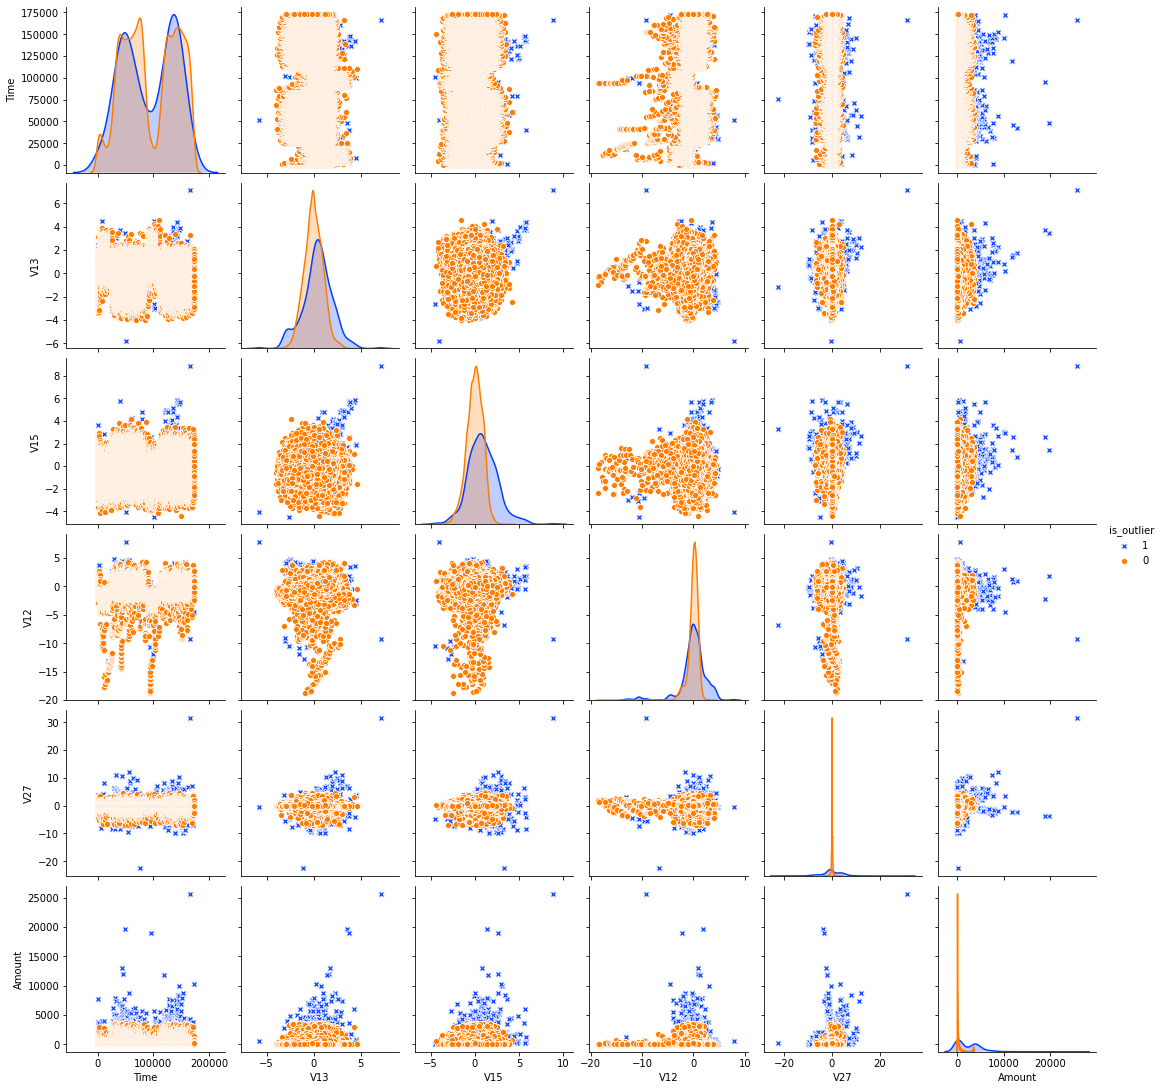

In [31]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = euclidian_outliers

sns.pairplot(data=labeled_data, vars = data_features[['Time', 'V13', 'V15', 'V12', 'V27', 'Amount']],
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

В целом мы получили схожую картину, что и при двух предыдущих методах.
Рассчитаем метрики качества.

In [32]:
eucl_data = pd.concat((labeled_data[['is_outlier']], data['Class']), axis=1)
eucl_data['is_outlier'] = np.where(eucl_data['is_outlier'] == True, 1, 0)
eucl_data.head()

,is_outlier,Class
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [33]:
eucl_report = quality_report(eucl_data['is_outlier'], eucl_data['Class'], 'euclidean')
eucl_report

,Accuracy,Precision,Recall,f1_score
euclidean,0.997,0.037,0.037,0.037


Как мы видим, при использовании данной модели у нас вырастает точность модели (Accuracy), также расчет Recall.

Теперь попробуем использовать другую метрику для поиска аномалий.

In [34]:
cityblock_model = DistanceOutliers(metric='cityblock', percentile=anomaly_percent)
cityblock_model.fit(scaled_data)
cityblock_outliers = cityblock_model.predict(scaled_data)
anomalies_report(cityblock_outliers)

Total number of outliers: 492
Percentage of outliers:   0.17%


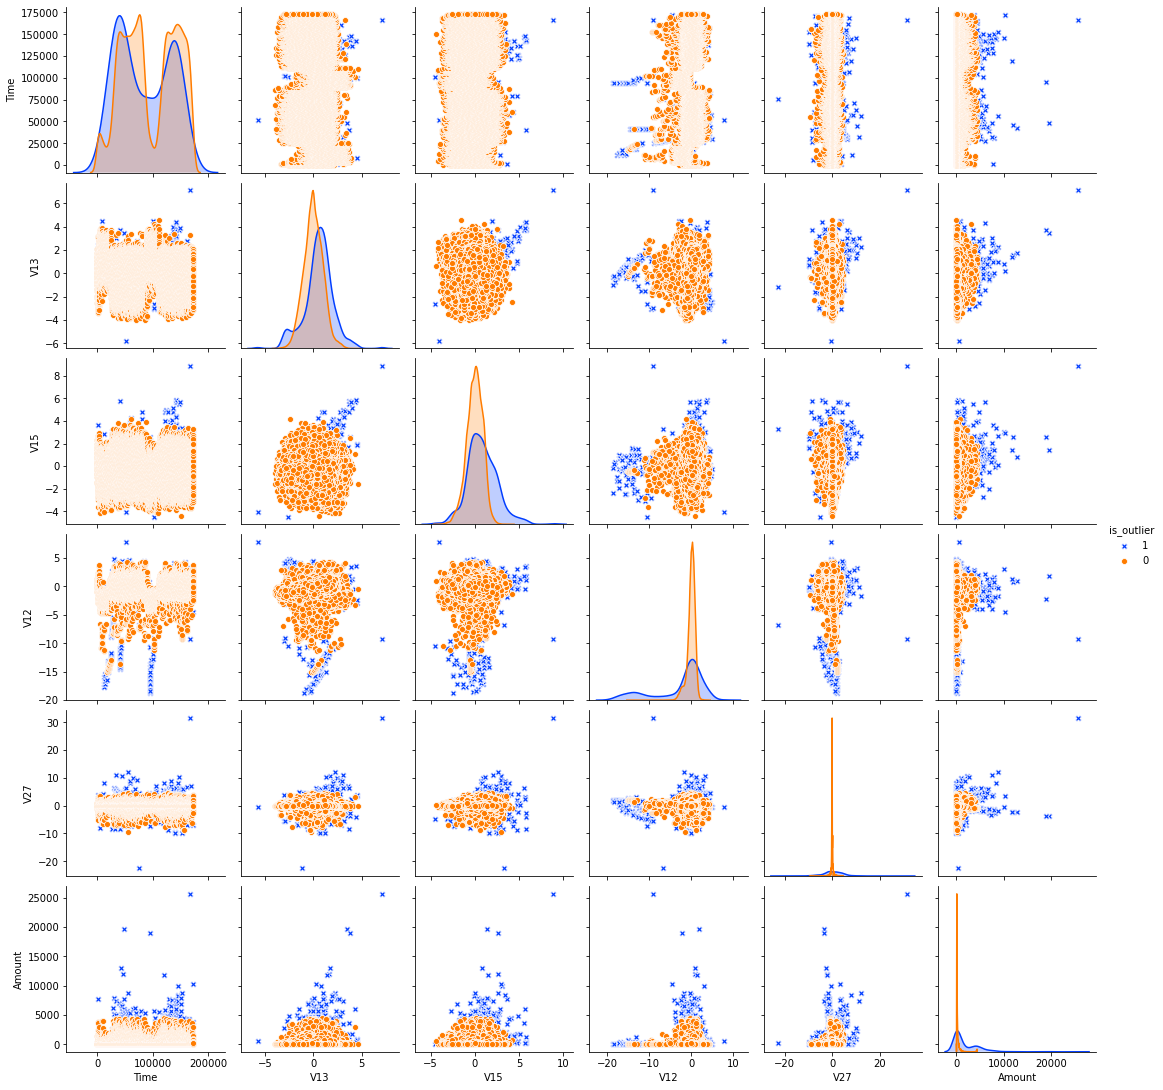

In [35]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = cityblock_outliers

sns.pairplot(data=labeled_data, vars = data_features[['Time', 'V13', 'V15', 'V12', 'V27', 'Amount']],
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

В целом мы наблюдаем схожую картину, что и при евклидовой метрике.
Рассчитаем метрики качества.

In [36]:
city_data = pd.concat((labeled_data[['is_outlier']], data['Class']), axis=1)
city_data['is_outlier'] = np.where(city_data['is_outlier'] == True, 1, 0)
city_data.head()

,is_outlier,Class
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [37]:
city_report = quality_report(city_data['is_outlier'], city_data['Class'], 'cityblock')
city_report

,Accuracy,Precision,Recall,f1_score
cityblock,0.997,0.228,0.228,0.228


Как мы видим, при данной метрики у нас значительно выросла метрика Recall в сравнении с остальными методами.

## One Class SVM

Далее найдем аномальные значения с помощью метода One Class SVM.

In [38]:
anomaly = (100 - anomaly_percent) / 100
anomaly

0.0017274856306201513

In [39]:
one_class_svm = OneClassSVM(nu=anomaly, gamma='auto')
one_class_svm.fit(scaled_data)
svm_outliers = one_class_svm.predict(scaled_data)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

In [40]:
anomalies_report(svm_outliers)

Total number of outliers: 2776
Percentage of outliers:   0.97%


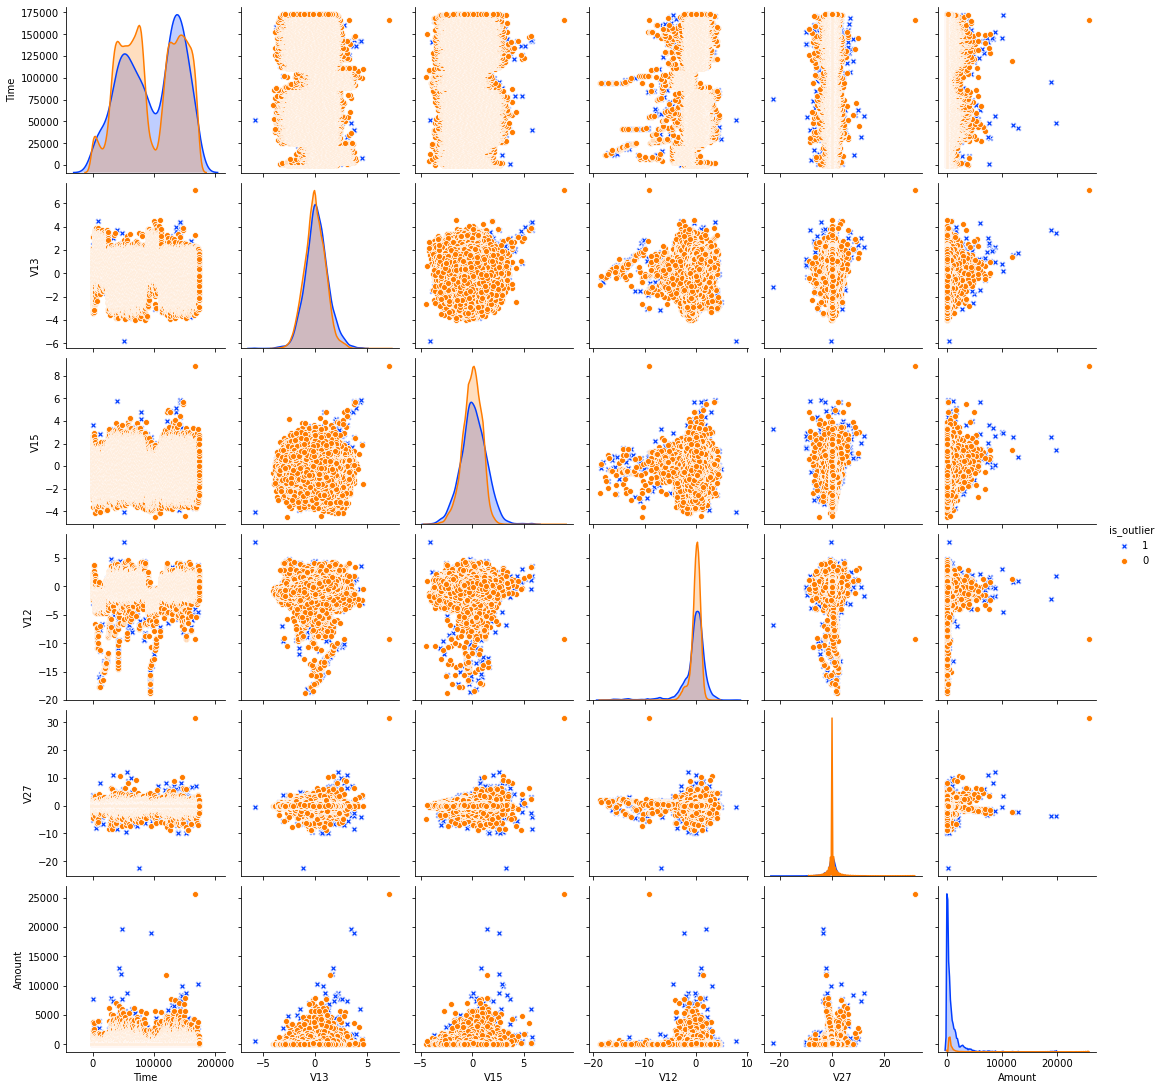

In [41]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = svm_outliers

sns.pairplot(data=labeled_data, vars = data_features[['Time', 'V13', 'V15', 'V12', 'V27', 'Amount']],
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

В целом мы наблюдаем схожую картину, что и при других методах.
Рассчитаем метрики качества.

In [42]:
svm_data = pd.concat((labeled_data[['is_outlier']], data['Class']), axis=1)
svm_data['is_outlier'] = np.where(svm_data['is_outlier'] == True, 1, 0)
svm_data.head()

,is_outlier,Class
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [43]:
svm_report = quality_report(svm_data['is_outlier'], svm_data['Class'], 'svm')
svm_report

,Accuracy,Precision,Recall,f1_score
svm,0.99,0.301,0.053,0.091


Мы видим, что при данном методе у нас высокое Accuracy, но при этом низкий Recall.

## Isolation Forest

Далее найдем аномальные значения с помощью метода Isolation Forest.

In [44]:
isolation_forest = IsolationForest(n_estimators=100, contamination=anomaly, 
                                   max_features=1.0, bootstrap=True, behaviour='new')
isolation_forest.fit(scaled_data)

isolation_outliers = isolation_forest.predict(scaled_data)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


In [45]:
anomalies_report(isolation_outliers)

Total number of outliers: 492
Percentage of outliers:   0.17%


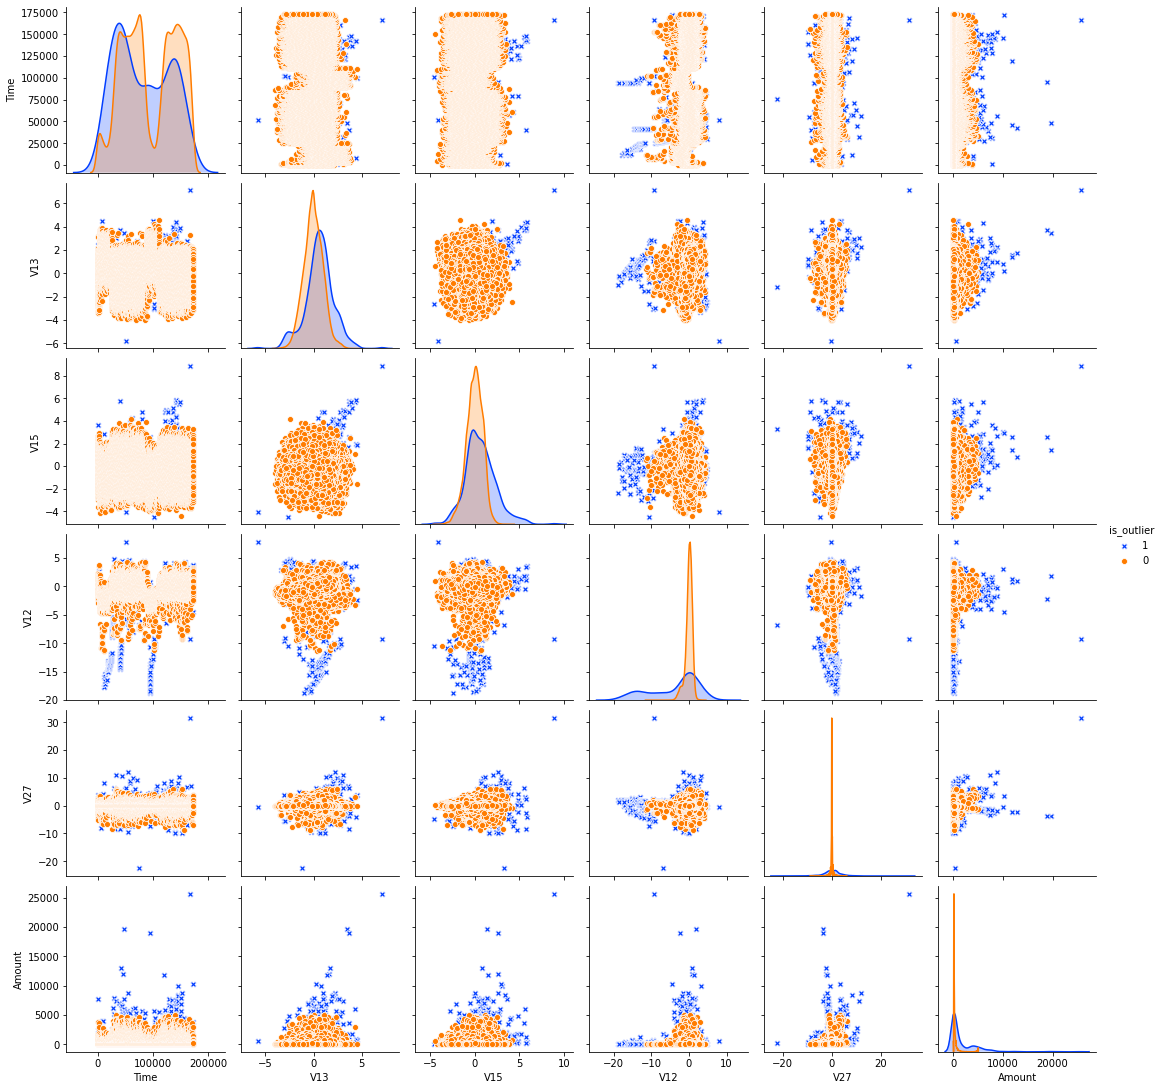

In [46]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = isolation_outliers

sns.pairplot(data=labeled_data, vars = data_features[['Time', 'V13', 'V15', 'V12', 'V27', 'Amount']],
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

В целом мы наблюдаем схожую картину, что и при других методах.
Рассчитаем метрики качества.

In [47]:
isf_data = pd.concat((labeled_data[['is_outlier']], data['Class']), axis=1)
isf_data['is_outlier'] = np.where(isf_data['is_outlier'] == True, 1, 0)
isf_data.head()

,is_outlier,Class
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [48]:
isf_report = quality_report(isf_data['is_outlier'], isf_data['Class'], 'isolation forest')
isf_report

,Accuracy,Precision,Recall,f1_score
isolation forest,0.998,0.299,0.299,0.299


По данной модели мы получаем самый высокий Recall, в сравнении с остальными методами поиска аномалий.

# DBSCAN
Теперь найдем аномалии при помощи метода кластеризации DBSCAN. Для ускорения процесса работы метода возьмем 10% выборки.

In [49]:
data_sample = data.sample(frac=0.1, random_state=123)
data_sample = data_sample.reset_index(drop=True)
data_sample.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,54992.0,-0.623235,1.097949,0.748810,0.763394,-0.179458,-0.258895,0.430106,0.466788,-0.935937,...,0.243136,0.468435,-0.055127,-0.012280,-0.236499,-0.327825,0.023302,0.089418,50.00,0
1,145983.0,2.155748,-0.998223,-1.158978,-0.992298,-0.484600,-0.308857,-0.677077,-0.193517,-0.083026,...,0.174775,0.519005,0.003460,-1.017962,-0.009465,-0.118435,-0.006350,-0.053375,58.00,0
2,142073.0,1.614893,-0.194953,-2.050402,1.469645,0.540352,-0.665439,0.677713,-0.246032,-0.079937,...,-0.029061,-0.369654,-0.071308,-0.520915,0.091351,-0.749140,-0.023202,-0.003519,198.00,0
3,132462.0,1.908756,-2.517443,0.277391,-1.466555,-1.521858,3.005920,-2.800770,0.981435,0.349534,...,0.050867,0.984547,0.163995,-0.905736,-0.511626,0.097492,0.147579,-0.036551,82.00,0
4,119001.0,2.120853,-1.048240,-1.895990,-1.236063,-0.038722,-0.274832,-0.388942,-0.196979,-0.649028,...,0.455959,1.125977,-0.263681,-1.322770,0.308495,0.132642,-0.057106,-0.074845,93.75,0


In [50]:
len(data_sample)

28481

In [51]:
(data_sample['Class'].value_counts() / len(data_sample)) * 100

0    99.820933
1     0.179067
Name: Class, dtype: float64

In [52]:
data_sample_features = data_sample.iloc[:, :-1]

In [53]:
anomaly_percent_smpl = (len(data_sample[data_sample['Class'] == 0]) / len(data_sample)) * 100
anomaly_percent_smpl

99.82093325374811

In [54]:
anomaly_smpl = (100 - anomaly_percent_smpl) / 100
anomaly_smpl

0.001790667462518911

In [55]:
scaled_data_sample = pd.DataFrame(
    data=scaler.fit_transform(data_sample_features), 
    columns=data_sample_features.columns
)

In [56]:
%%time
# для начала считаем все наблюдения аномальными
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# зададим эпсилон, приближенный к нашему проценту аномалий, и начинем увеличивать
eps = 20.5
eps_history = [eps]
while outlier_percentage>anomaly_smpl:    
    print(outlier_percentage)
    print(eps)
    model = DBSCAN(eps=eps).fit(scaled_data_sample)
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    # считаем текущий процент "шума"
    outlier_percentage = sum(labels==1) / len(labels)    
    eps += 0.05
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)
    
model = DBSCAN(eps)
model.fit(scaled_data_sample)
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])

1.0
20.5
0.0018608897159509848
20.55
0.0018608897159509848
20.6
0.0018608897159509848
20.650000000000002
0.0018608897159509848
20.700000000000003
0.0018257785892349286
20.750000000000004
0.0018257785892349286
20.800000000000004
0.0018257785892349286
20.850000000000005
Wall time: 5min 29s


In [57]:
anomalies_report(density_outlier)

Total number of outliers: 51
Percentage of outliers:   0.18%


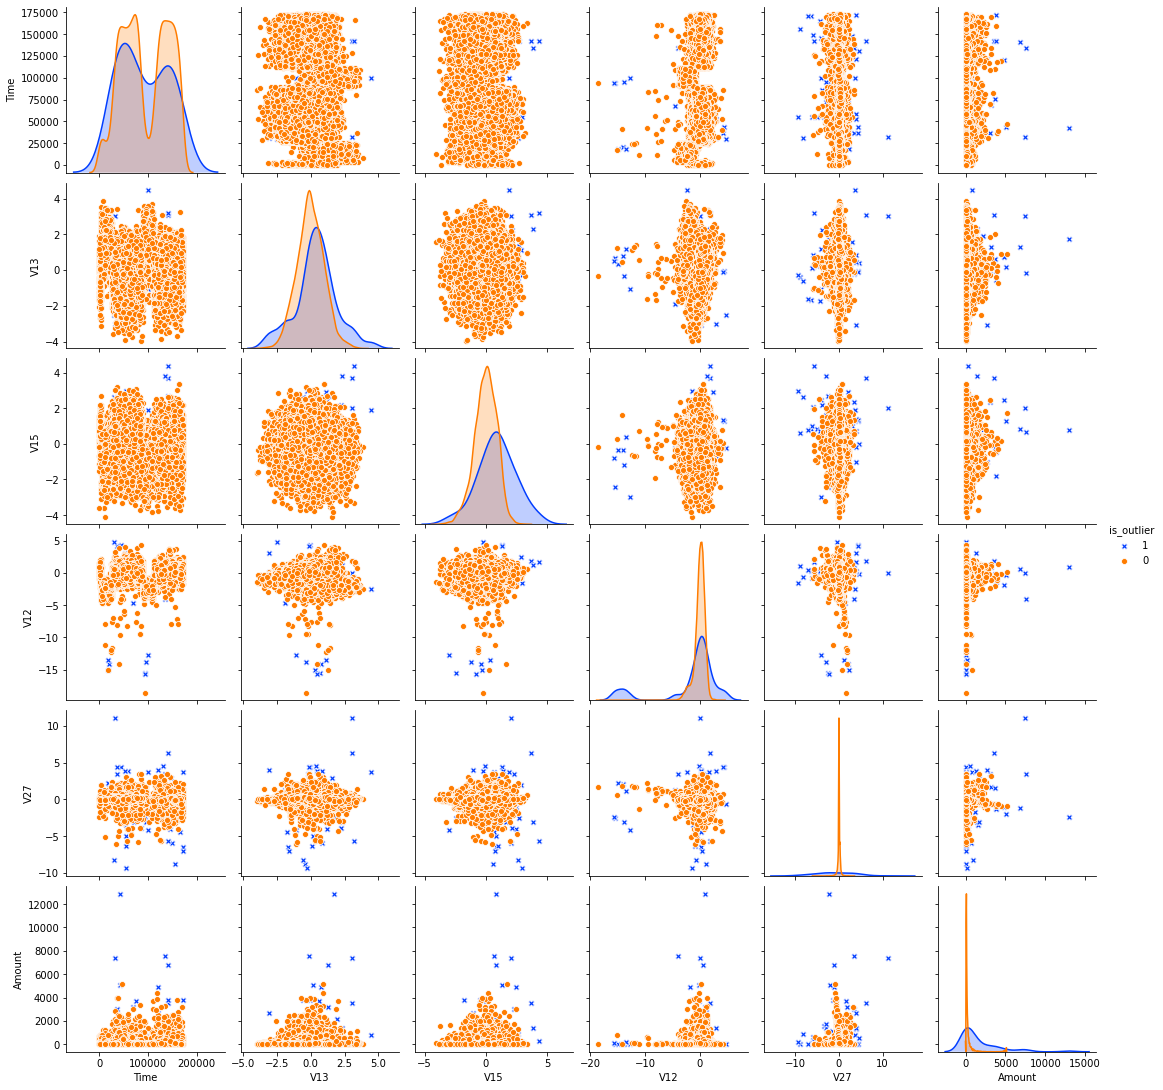

In [58]:
labeled_data = data_sample_features.copy()
labeled_data['is_outlier'] = density_outlier

sns.pairplot(data=labeled_data, vars = data_sample_features[['Time', 'V13', 'V15', 'V12', 'V27', 'Amount']],
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

В целом мы наблюдаем схожую картину, что и при других методах.
Рассчитаем метрики качества.

In [59]:
db_data = pd.concat((labeled_data[['is_outlier']], data_sample['Class']), axis=1)
db_data['is_outlier'] = np.where(db_data['is_outlier'] == True, 1, 0)
db_data.head()

,is_outlier,Class
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [60]:
db_report = quality_report(db_data['is_outlier'], db_data['Class'], 'dbscan')
db_report

,Accuracy,Precision,Recall,f1_score
dbscan,0.997,0.157,0.157,0.157


По данной модели мы получаем высокий Recall, но ниже, в сравнении с прошлым методом.

## Итоговое сравнение

Теперь сравним все методы по метрикам качества.

In [61]:
final_report = pd.concat((std_report, iqr_report, eucl_report, city_report, svm_report, isf_report, db_report), axis=0)
final_report

,Accuracy,Precision,Recall,f1_score
std,0.869,0.902,0.012,0.023
iqr,0.814,0.919,0.008,0.017
euclidean,0.997,0.037,0.037,0.037
cityblock,0.997,0.228,0.228,0.228
svm,0.990,0.301,0.053,0.091
isolation forest,0.998,0.299,0.299,0.299
dbscan,0.997,0.157,0.157,0.157


Как мы видим, при использовании классических методов поиска аномалий у нас страдает Accuracy. Также мы получаем низкий Recall (т.е. данные методы практически не находят реальные аномалии).
При использовании моделей мы значительно повышаем Accuracy, и у нас увеличивается Recall (мы начинаем угадывать больше реальных аномалий).
С учетом этого, можно сделать вывод, что лучшей моделей для поиска аномалий в нашем датасете (при знании реального %-та аномалий) является модель IsolationForest. Также неплохо себя показывает модель на основе расстояний с использованием метрики cityblock и модель DBSCAN.

## UMAP

Теперь построим сжатое предоставление наших данных и посмотрим далеко ли лежат аномалии от основной массы точек. При помощи метода UMAP

In [2]:
um = umap.UMAP(random_state=42)
um_transformed = um.fit_transform(scaled_data)

plt.figure(figsize=(10, 10))
plt.scatter(um_transformed[:, 0], um_transformed[:, 1], c=isolation_outliers)

AttributeError: module 'umap' has no attribute 'UMAP'